# Imports

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os,glob,sys
import PIL
import tensorflow as tf
import imageio
from tensorflow.keras.backend import clear_session
from keras.initializers import RandomNormal
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import time 

### Using this post as a guide to some of the modifications in the code
https://towardsdatascience.com/10-lessons-i-learned-training-generative-adversarial-networks-gans-for-a-year-c9071159628

In [12]:
# To generate GIFs
!pip install -q imageio
!pip install -q git+https://github.com/tensorflow/docs

     |████████████████████████████████| 1.0MB 6.9MB/s 


# function definitions

In [13]:
# create discriminator model
def discriminator(image_shape):

    # we go from shape (w, h, 1)to shape 
	# downsample to 14x14
  init = RandomNormal(stddev=0.02)
  i = Input(shape=(image_shape))
  x = Conv2D(64, (3,3), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(i)
  x = Dropout(0.3)(x)
  # downsample to 7x7
  x = Conv2D(32, (3,3), strides=(2,2), padding='same', activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(x)
  x = Dropout(0.3)(x)
  x = Flatten()(x)
  x = Dense(1,activation='sigmoid')(x)

  return Model(i, x)


# create generator model
def generator(latent_dim):

  #### the returned model has output image of shape (28,28,1) just like the mnist dataset
  # we go from shape space_shape to shape (w, h ,1)
  n_nodes = 128 * 7 * 7
  init = RandomNormal(stddev=0.02)
  i = Input(shape=(latent_dim,))
  x = Dense(n_nodes, activation=LeakyReLU(alpha=0.2), kernel_initializer=init)(i)
  x = Reshape((7, 7, 128))(x)# we will start converting to image shapes to reverse conv
  x = Conv2DTranspose(128,(3,3),strides=(2, 2), padding='same', activation=LeakyReLU(0.2), kernel_initializer=init)(x) # upsample to 14x14
  x = Conv2DTranspose(128,(3,3),strides=(2, 2), padding='same', activation=LeakyReLU(0.2), kernel_initializer=init)(x) # upsample to 28x28
  x = Conv2D(1, (7,7), activation='tanh',padding='same', kernel_initializer=init)(x)

  return Model(i, x)


# create compound model
def gan(dis, gen):

  # build and compile discreminator
  dis.compile(loss='binary_crossentropy', optimizer=Adam(0.0005, 0.5),metrics=['accuracy'])
  dis.trainable = False # discreminator in combined model will not be trained
  latent_dim = gen.layers[0].input.shape[1]
  # Build and compile the combined model
  noise = Input(shape=(latent_dim,))# create noise input 
  img = gen(noise) # generate image from noise
  fake_pred = dis(img)
  combined_model = Model(noise, fake_pred)  # # Create the combined model object
  combined_model.compile(loss='binary_crossentropy', optimizer=Adam(0.0001, 0.5))

  return combined_model , dis ,gen


def sample_images(epoch, gen):
  rows, cols = 5, 5
  noise = np.random.randn(rows * cols, LATENT_DIM)
  imgs = gen.predict(noise)

  # Rescale images 0 - 1
  imgs = 0.5 * imgs + 0.5

  fig, axs = plt.subplots(rows, cols,figsize=(15,15))
  idx = 0
  for i in range(rows):
    for j in range(cols):
      axs[i,j].imshow(imgs[idx].reshape(h, w), cmap='gray')
      axs[i,j].axis('off')
      idx += 1

  fig.savefig(f'gan_images/{epoch}.png')
  plt.close()


def train(combined=None, dis=None, gen=None, BATCH_SIZE= 64, EPHOCHS= 100, CHECKPOINT=100, LATENT_DIM=None, train_cycle=1):
  
  if not os.path.exists('gan_images'):
    os.makedirs('gan_images')
  checkpoint_dir = './training_checkpoints'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  ones = tf.ones([BATCH_SIZE,1]) 
  zeros = tf.zeros([BATCH_SIZE,1])
  d_losses = []
  g_losses = []

  if train_cycle == 1:
    start_range = 1
  else:
    start_range = EPHOCHS * (train_cycle - 1)
    
  print(f'Training will coninue from epoch {start_range} and will finish at epoch. {train_cycle * EPHOCHS}')
  start = time.time()
  for epoch in range(start_range , train_cycle * EPHOCHS + 1):
    
    fake = tf.random.normal((BATCH_SIZE,LATENT_DIM))
    fake = gen.predict(fake)
    idx = tf.random.uniform(shape=(BATCH_SIZE,1), minval=0,maxval=x_train.shape[0],dtype=tf.dtypes.int32)
    real_imgs = x_train[idx]
    real_imgs = real_imgs.reshape(BATCH_SIZE, w, h , 1)

    # train discriminator
    d_loss_real, d_acc_real = dis.train_on_batch(real_imgs, ones)
    d_loss_fake, d_acc_fake = dis.train_on_batch(fake, zeros)
    dis_loss = 0.5 * (d_loss_real + d_loss_fake)
    dis_acc =  0.5 * (d_acc_real + d_acc_fake)

    # train combined
    noise = tf.random.normal([BATCH_SIZE,LATENT_DIM])# create noise input 
    gen_loss = combined.train_on_batch(noise, ones)

    # do it again!
    noise = tf.random.normal([BATCH_SIZE,LATENT_DIM])# create noise input 
    gen_loss = combined.train_on_batch(noise, ones)

    # # do it again!
    # noise = tf.random.normal([BATCH_SIZE,LATENT_DIM])# create noise input 
    # gen_loss = combined.train_on_batch(noise, ones)
    
    if epoch  % CHECKPOINT == 0:
      # save checkpoint and images
      # print('checkpoint saved') 
      combined.save_weights(os.path.join(checkpoint_prefix, f'combined_epoch_{epoch}'))
      dis.save_weights(os.path.join(checkpoint_prefix, f'dis_epoch_{epoch}'))
      gen.save_weights(os.path.join(checkpoint_prefix, f'gen_epoch_{epoch}'))
      sample_images(epoch, gen)
      print(f"epoch: {epoch}/{train_cycle * EPHOCHS}, time: {(time.time()-start):.2f}s , d_loss: {dis_loss:.2f}, d_acc: {dis_acc:.2f}, g_loss: {gen_loss:.2f}")
      start = time.time()

    d_losses.append(dis_loss)
    g_losses.append(gen_loss)

  return g_losses, d_losses , combined, dis, gen

# load dataset 

In [14]:
#load mnist data
(x_train, y_train), (_,_)  = tf.keras.datasets.mnist.load_data()
x_train = x_train / 255.0 * 2 - 1 # reshape from 0-255 to -1 1 
w = x_train[0].shape[0]
h = x_train[0].shape[1]
# x_train = x_train.reshape(-1, w, h, 1)
x_train.shape

(60000, 28, 28)

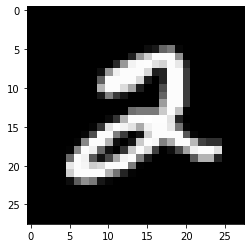

In [15]:
plt.imshow(x_train[5].reshape(w,h),cmap='gray')

In [16]:
# clear old checkpoint to start new
! rm -rf ./training_checkpoints
!rm -rf gan_images
!rm -rf dcgan.gif

# Train GAN

In [17]:
IMAGE_SHAPE = x_train[0].shape
IMAGE_SHAPE = IMAGE_SHAPE + (1 ,)
LATENT_DIM = 100
BATCH_SIZE = 128
EPHOCHS = 10000
CHECKPOINT = 100
clear_session() # clearing seession so when new models created the have same layer names and saved models
dis = discriminator(IMAGE_SHAPE)
gen = generator(LATENT_DIM)
combined , dis, gen = gan(dis, gen)

In [18]:
old_train_cycle = 0
g_losses, d_losses, c, d, g = train(combined, dis, gen, BATCH_SIZE, EPHOCHS, CHECKPOINT, LATENT_DIM, train_cycle=old_train_cycle+1)
old_train_cycle  += 1

Training will coninue from epoch 1 and will finish at epoch. 10000
epoch: 100/10000, time: 23.05s , d_loss: 0.72, d_acc: 0.52, g_loss: 0.86
epoch: 200/10000, time: 15.21s , d_loss: 0.68, d_acc: 0.53, g_loss: 0.81
epoch: 300/10000, time: 15.07s , d_loss: 0.67, d_acc: 0.61, g_loss: 0.76
epoch: 400/10000, time: 14.91s , d_loss: 0.67, d_acc: 0.59, g_loss: 0.76
epoch: 500/10000, time: 15.12s , d_loss: 0.70, d_acc: 0.49, g_loss: 0.68
epoch: 600/10000, time: 15.48s , d_loss: 0.68, d_acc: 0.60, g_loss: 0.72
epoch: 700/10000, time: 15.40s , d_loss: 0.69, d_acc: 0.57, g_loss: 0.73
epoch: 800/10000, time: 15.98s , d_loss: 0.68, d_acc: 0.55, g_loss: 0.70
epoch: 900/10000, time: 15.33s , d_loss: 0.66, d_acc: 0.70, g_loss: 0.78
epoch: 1000/10000, time: 15.11s , d_loss: 0.68, d_acc: 0.58, g_loss: 0.72
epoch: 1100/10000, time: 15.03s , d_loss: 0.72, d_acc: 0.46, g_loss: 0.66
epoch: 1200/10000, time: 14.68s , d_loss: 0.70, d_acc: 0.46, g_loss: 0.69
epoch: 1300/10000, time: 14.87s , d_loss: 0.69, d_acc:

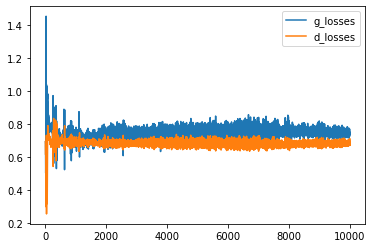

In [19]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

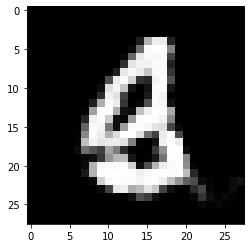

In [20]:
noise = tf.random.normal([1,LATENT_DIM])# create noise input 
imgs = g.predict(noise)
out = d.predict(imgs)
# # Rescale images 0 - 1
imgs = 0.5 * imgs + 0.5

plt.imshow(imgs[0].reshape(w, h),cmap='gray')


In [35]:
### try to reload trained weights and continue training
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
dis2 = discriminator(IMAGE_SHAPE)
dis2.load_weights(os.path.join(checkpoint_prefix, f'dis_epoch_{EPHOCHS * old_train_cycle}'))
gen2 = generator(LATENT_DIM)
gen2.load_weights(os.path.join(checkpoint_prefix, f'gen_epoch_{EPHOCHS * old_train_cycle}'))
combined2 , dis2, gen2 = gan(dis2, gen2)
combined2.load_weights(os.path.join(checkpoint_prefix, f'combined_epoch_{EPHOCHS * old_train_cycle}'))


In [36]:
g_losses, d_losses, c, d, g = train(combined2, dis2, gen2, BATCH_SIZE, EPHOCHS, CHECKPOINT, LATENT_DIM, train_cycle=old_train_cycle+1)
old_train_cycle += 1 

Training will coninue from epoch 20000 and will finish at epoch. 30000
epoch: 20000/30000, time: 1.88s , d_loss: 0.69, d_acc: 0.52, g_loss: 0.72
epoch: 20100/30000, time: 14.92s , d_loss: 0.69, d_acc: 0.51, g_loss: 0.71
epoch: 20200/30000, time: 14.94s , d_loss: 0.69, d_acc: 0.48, g_loss: 0.71
epoch: 20300/30000, time: 14.86s , d_loss: 0.70, d_acc: 0.44, g_loss: 0.71
epoch: 20400/30000, time: 14.83s , d_loss: 0.69, d_acc: 0.51, g_loss: 0.70
epoch: 20500/30000, time: 14.93s , d_loss: 0.70, d_acc: 0.52, g_loss: 0.70
epoch: 20600/30000, time: 19.08s , d_loss: 0.69, d_acc: 0.54, g_loss: 0.70
epoch: 20700/30000, time: 15.01s , d_loss: 0.70, d_acc: 0.50, g_loss: 0.70
epoch: 20800/30000, time: 15.03s , d_loss: 0.70, d_acc: 0.48, g_loss: 0.70
epoch: 20900/30000, time: 15.25s , d_loss: 0.70, d_acc: 0.49, g_loss: 0.71
epoch: 21000/30000, time: 15.09s , d_loss: 0.70, d_acc: 0.51, g_loss: 0.70
epoch: 21100/30000, time: 15.07s , d_loss: 0.69, d_acc: 0.53, g_loss: 0.71
epoch: 21200/30000, time: 14.9

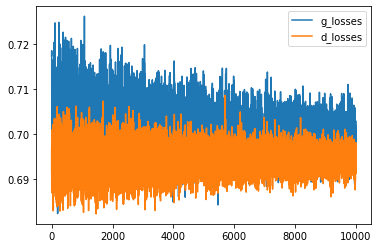

In [37]:
plt.plot(g_losses, label='g_losses')
plt.plot(d_losses, label='d_losses')
plt.legend()

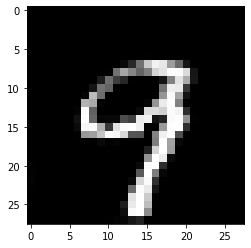

In [38]:
noise = tf.random.normal([1,LATENT_DIM])# create noise input 
imgs = g.predict(noise)
out = d.predict(imgs)
# # Rescale images 0 - 1
imgs = 0.5 * imgs + 0.5

plt.imshow(imgs[0].reshape(w, h),cmap='gray')


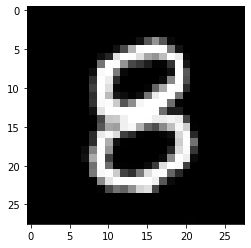

In [49]:
 # try loading train generator 
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
gen3 = None
gen3 = generator(LATENT_DIM)
gen3.load_weights(os.path.join(checkpoint_prefix, f'gen_epoch_{(old_train_cycle)* EPHOCHS}'))
noise = tf.random.normal([1,LATENT_DIM])# create noise input 
imgs = gen2.predict(noise)
# # Rescale images 0 - 1
imgs = 0.5 * imgs + 0.5
plt.imshow(imgs[0].reshape(w, h),cmap='gray')


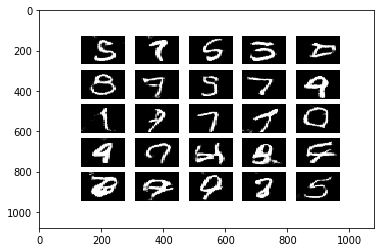

In [40]:
def display_image(epoch_no):
  return PIL.Image.open(f'gan_images/{epoch_no}.png')
img = display_image(30000)
img = np.array(img)

plt.imshow(img, interpolation='nearest', aspect='auto')

In [41]:
anim_file = 'dcgan.gif'
with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('gan_images/*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [50]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)